In [70]:
import pickle
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=200
RANDSTATE = 42

In [2]:
with open("Data/data.pkl", "rb") as fp:   # Unpickling
    data_list = pickle.load(fp)
    
xpts, ypts, zpts, _, magpts = data_list

In [3]:
# check data
assert(len(xpts)==len(ypts) and len(xpts)==len(zpts) and len(xpts)==len(magpts))

In [4]:
# Transform the data into X, y form
n = len(xpts)
d = 3
X = np.array([xpts, ypts, zpts]).T
y = np.array(magpts)

In [140]:
def valid_acc(model, dataset):
    y_predict = model.predict(dataset.valid_X)
    valid_acc = accuracy_score(dataset.valid_y, y_predict)
    return valid_acc

class MyDataset():
    def __init__(self, train_X, valid_X, train_y, valid_y, X_test = None):
        self.X_train = train_X
        self.y_train = train_y
        self.X_valid = valid_X
        self.y_valid = valid_y
        self.X_test = X_test
        
        self.normalized = False
        
    def __str__(self):
        return str((self.train_X.shape, self.train_y.shape, self.valid_X.shape, self.valid_y.shape))

    def normalize(self):
        if self.normalized:
            print("already normalized!")
            return
        
        std_list = np.std(self.X_train, axis=0)
        std_list = np.where(std_list == 0, 1, std_list) # prevent zero division error
        avg_list = np.mean(self.X_train, axis=0)
        self.X_train = (self.X_train - avg_list)/std_list
        if not self.X_valid is None: self.X_valid = (self.X_valid - avg_list)/std_list
        if not self.X_test is None: self.X_test = (self.X_test - avg_list)/std_list
            
        self.std_list = std_list
        self.avg_list = avg_list
        print("dataset normalized!")
        self.normalized = True
        return
    
    def normalize_vec(self, X):
        if not self.normalized:
            print("Dataset never normalized")
        return (X - self.avg_list)/self.std_list
    
    def add_fict(self):
        add_ones = lambda X: np.hstack((X,np.ones((X.shape[0],1))))
        self.X_train = add_ones(self.X_train)
        self.X_valid = add_ones(self.X_valid)
        self.X_test = add_ones(self.X_test)
        print("ficticious dimension added!")
        
    def print_dim(self):
        print("X_train has shape:",self.X_train.shape)
        print("y_train has shape:",self.y_train.shape)
        print("X_valid has shape:",self.X_valid.shape)
        print("y_valid has shape:",self.y_valid.shape)
        if self.X_test: print("X_test has shape:",self.X_test.shape)

def train(dataset, n_using, C = 1):
    # to use all data, use n_using = -1
    X, y = dataset.train_X, dataset.train_y
    X, y = X[:n_using], y[:n_using].ravel()
    model = SVC(kernel='linear', C=C)
    model.fit(X, y)
    
    y_predict = model.predict(X)
    train_acc = accuracy_score(y, y_predict)
    
    return model, train_acc

def test(model, dataset):
    # test a model on the validation set
    y_predict = model.predict(dataset.valid_X)
    valid_acc = accuracy_score(dataset.valid_y, y_predict)
    return valid_acc
    
def train_test(dataset, n_using):
    model, train_acc = train(dataset, n_using)
    valid_acc = test(model, dataset)
    return valid_acc, train_acc

def plot_acc(xl, yl, zl, filename, title):
    plt.plot(xl, yl, label="validation")
    plt.plot(xl, zl, label="training")
    plt.title(title)
    plt.xlabel("number of training data points")
    plt.ylabel("accuracy")
    plt.legend()
    plt.savefig(filename)
    plt.show()
    
# A code snippet to help you save your results into a kaggle accepted csv
def results_to_csv(y_test, title = 'submission.csv'):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv(title, index_label='Id')

In [141]:
# data loading
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=41) #!!! RANDSEED
venus = MyDataset(X_train, X_valid, y_train, y_valid)
venus.print_dim()

venus.normalize()

X_train has shape: (437, 3)
y_train has shape: (437,)
X_valid has shape: (188, 3)
y_valid has shape: (188,)
dataset normalized!


In [144]:
# venus.normalize_vec(X_valid)
# venus.X_valid

In [116]:
alpha = 0.15 # best value is 0.15
kernel = Matern(nu=0.66)
# kernel = RBF() #

gpr = GaussianProcessRegressor(kernel=kernel,random_state=0, alpha=alpha).fit(venus.X_train, venus.y_train)

# check
print("Train score: %f"%gpr.score(venus.X_train, venus.y_train))
print("Test score:  %f "%gpr.score(venus.X_valid, venus.y_valid))

# TODO: randomize test set
# TODO: plot variance on the same plots

Train score: 0.971724
Test score:  0.795451 


0.821644 for nu=0.400000
0.823044 for nu=0.466667
0.823796 for nu=0.533333
0.824135 for nu=0.600000


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.824200 for nu=0.666667
0.824079 for nu=0.733333
0.823827 for nu=0.800000
0.823484 for nu=0.866667
0.823078 for nu=0.933333
0.822629 for nu=1.000000


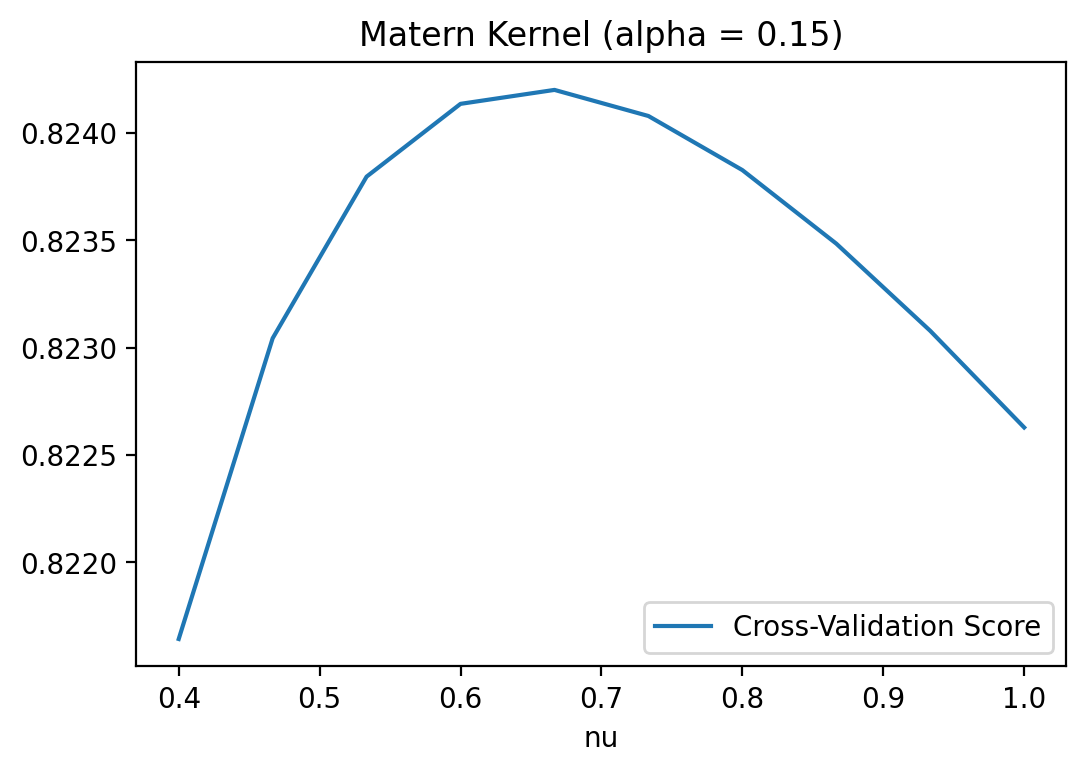

In [94]:
# Matern nu tuning
cv_score = []
nus = np.linspace(0.4, 1, 10)
relu = lambda x: x if x>0 else 0
for nu in nus:
    kernel = Matern(nu=nu)
    gpr = GaussianProcessRegressor(kernel=kernel,random_state=0, alpha=alpha).fit(venus.X_train, venus.y_train)
    cvs = cross_val_score(gpr, X, y)
    avg_cvs = sum(cvs)/len(cvs)
    print("%f for nu=%f"%(avg_cvs, nu))
    cv_score.append(avg_cvs)

cv_score = [relu(x) for x in cv_score]
plt.plot(nus, cv_score, label="Cross-Validation Score")
plt.legend()
plt.xlabel("nu")
plt.title("Matern Kernel (alpha = 0.15)")
plt.savefig("Matern nu.png")

In [153]:
# use all available data for the final model
kernel = Matern(nu=0.66)

venus_whole = MyDataset(X, None, y, None)
venus_whole.normalize()

gpr = GaussianProcessRegressor(kernel=kernel,random_state=1, alpha=alpha).fit(venus_whole.X_train, venus_whole.y_train)
print("Whole dataset training score: %f"%gpr.score(venus_whole.X_train, venus_whole.y_train))

dataset normalized!
Whole dataset training score: 0.971174


In [154]:
gpr.predict(venus_whole.X_train[1:2])

array([102.28116758])

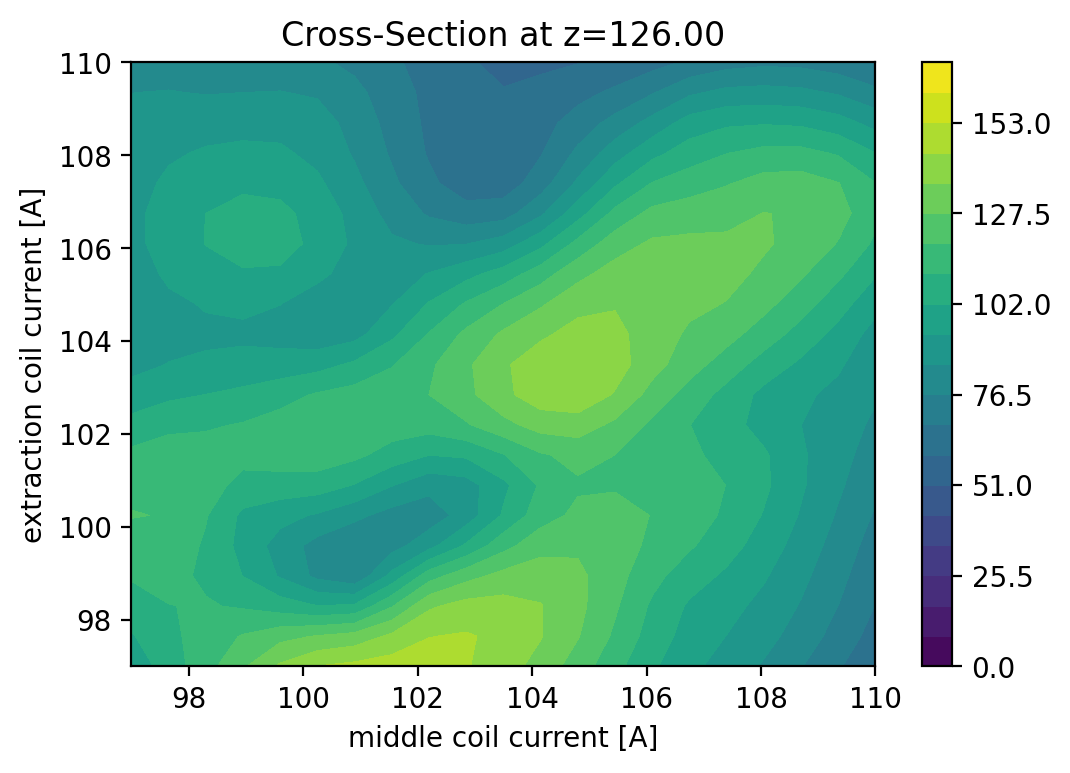

In [165]:
def plot_cross_section(gpr, z_plot, plotVar=False):
    def gauss_mean(x, y, z=123):
        arr = np.array([[x,y,z]])
        arr = venus_whole.normalize_vec(arr)
        result = gpr.predict(arr)
        return result
    
    def gauss_var(x, y, z=123):
        arr = np.array([[x,y,z]])
        arr = venus_whole.normalize_vec(arr)
        result = gpr.predict(arr, return_std=True)[1]
        return result
    if plotVar:
        func = gauss_var
    else:
        func = gauss_mean
    n_plot = 21
    x = np.linspace(97, 110, n_plot)
    y = np.linspace(97, 110, n_plot)
    z = np.array([func(i,j,z=z_plot) for j in y for i in x])

    X, Y = np.meshgrid(x, y)
    Z = z.reshape(n_plot, n_plot)
    
    levels = np.linspace(0, 1, n_plot) if plotVar else np.linspace(0, 170, n_plot)
    img=plt.contourf(X, Y, Z, levels=levels)
    plt.colorbar(img)
    
    
    plt.xlabel("middle coil current [A]")
    plt.ylabel("extraction coil current [A]")
    plt.title("Cross-Section at z=%.2f"%z_plot)
    filename = "Figures/GPRplots/var/z%d_var.png"%int(z_plot*10) if plotVar else "Figures/GPRplots/mean/z%d_mean.png"%int(z_plot*10)
    plt.savefig(filename)
    plt.show()
    return
plot_cross_section(gpr, 126, plotVar=False)

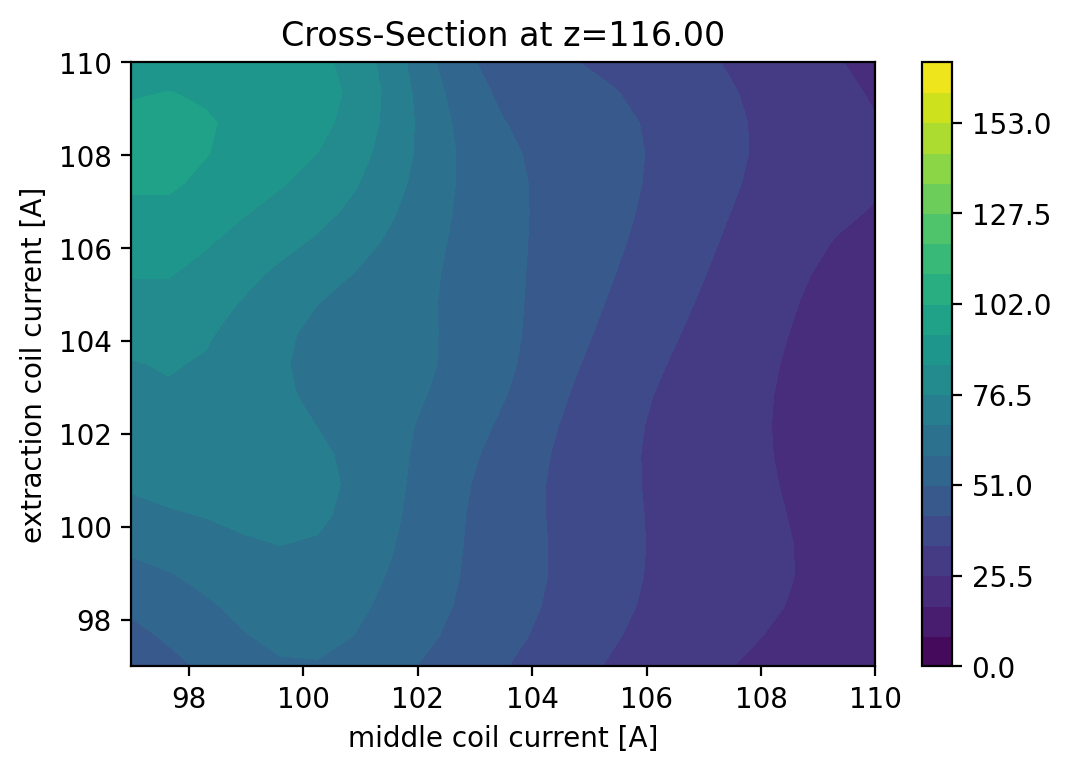

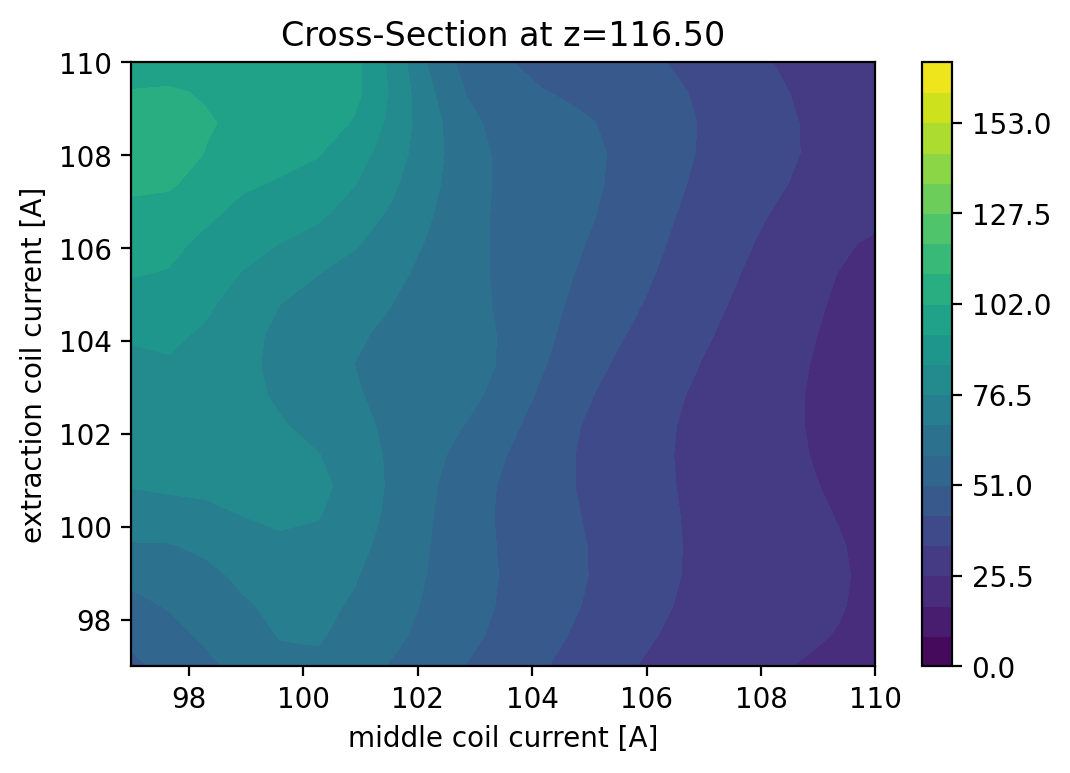

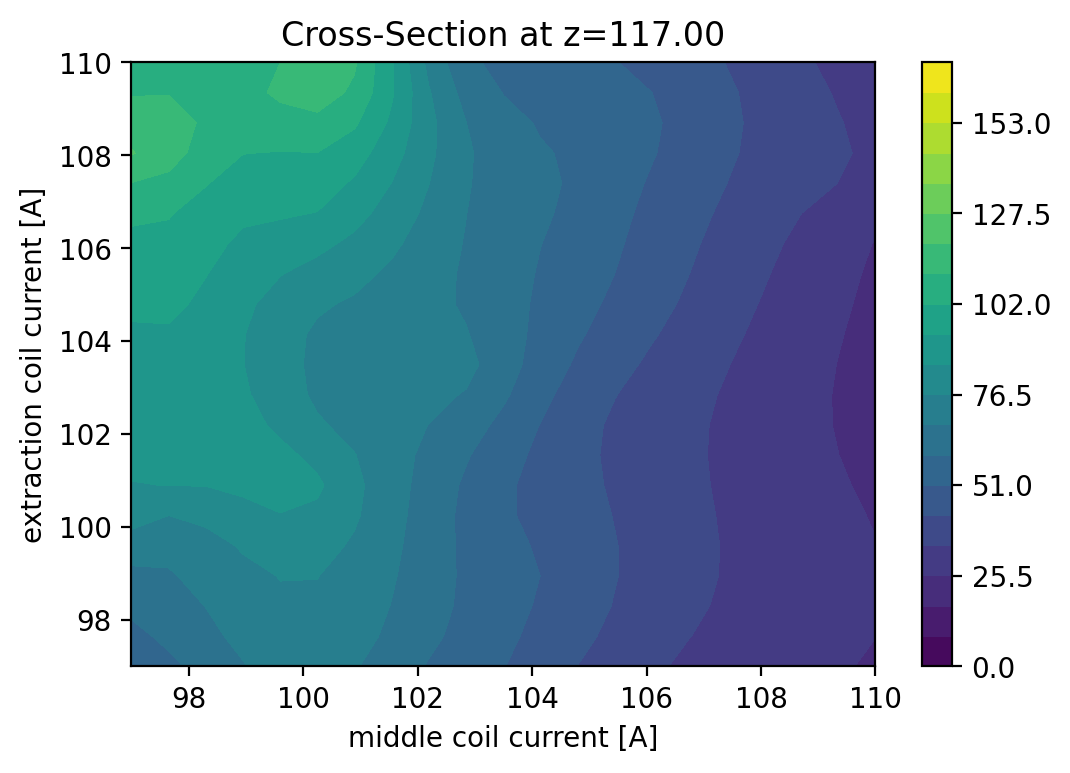

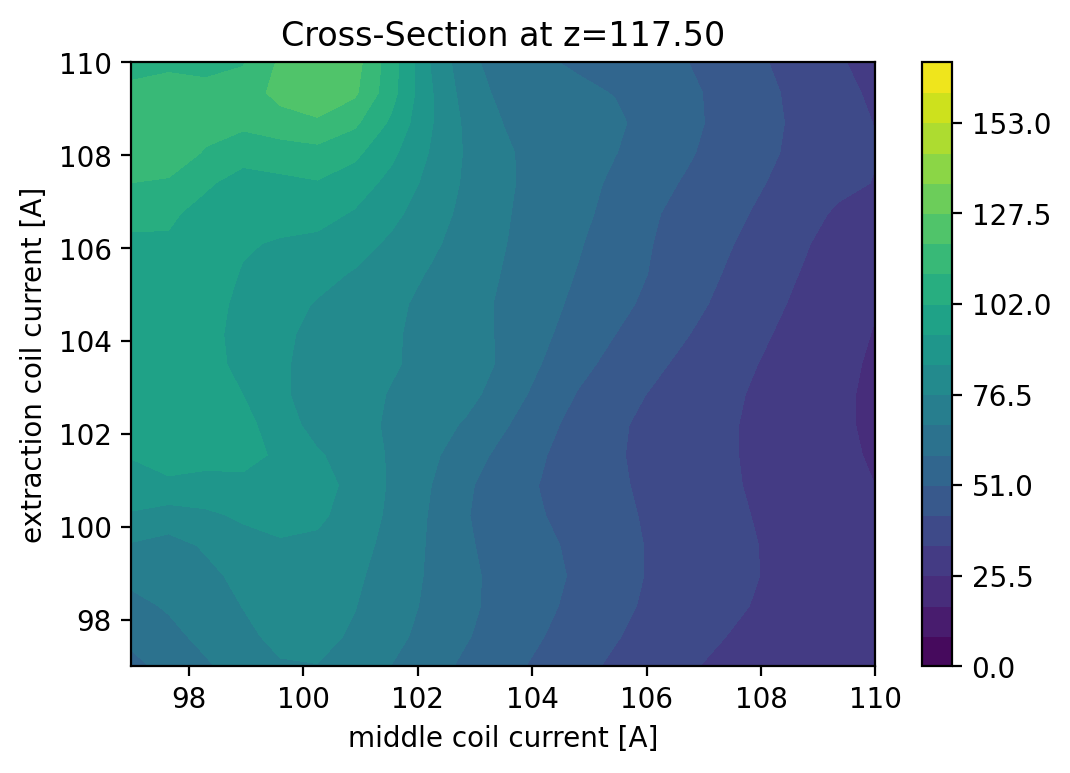

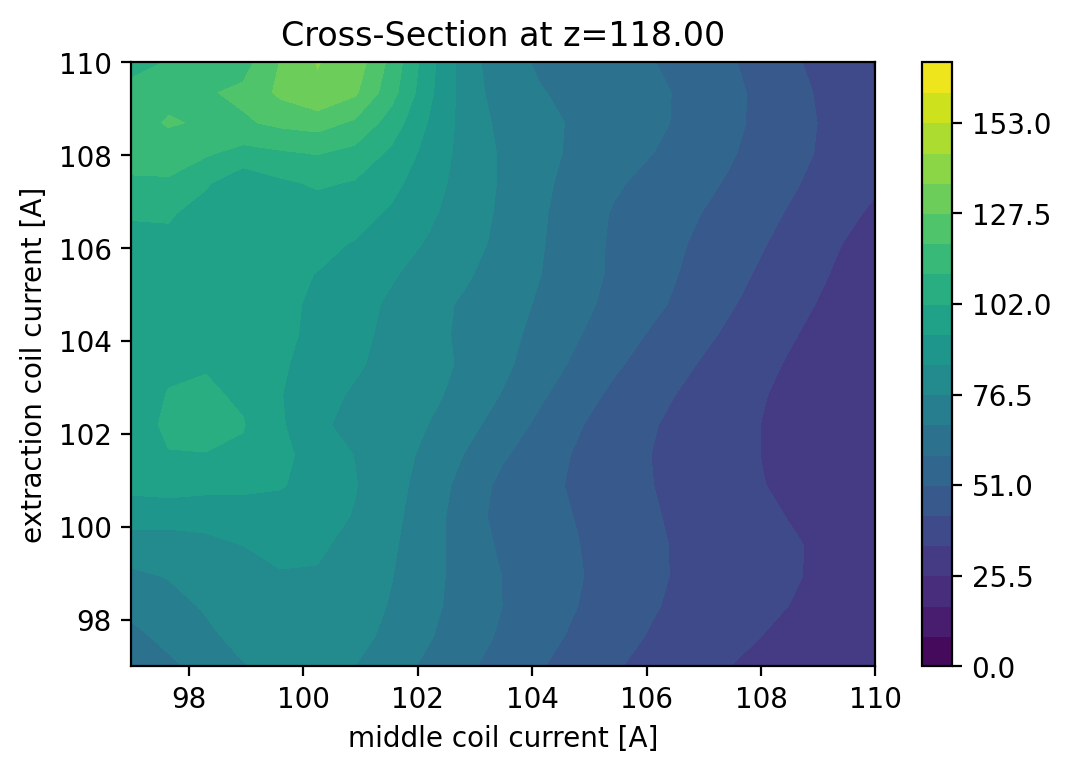

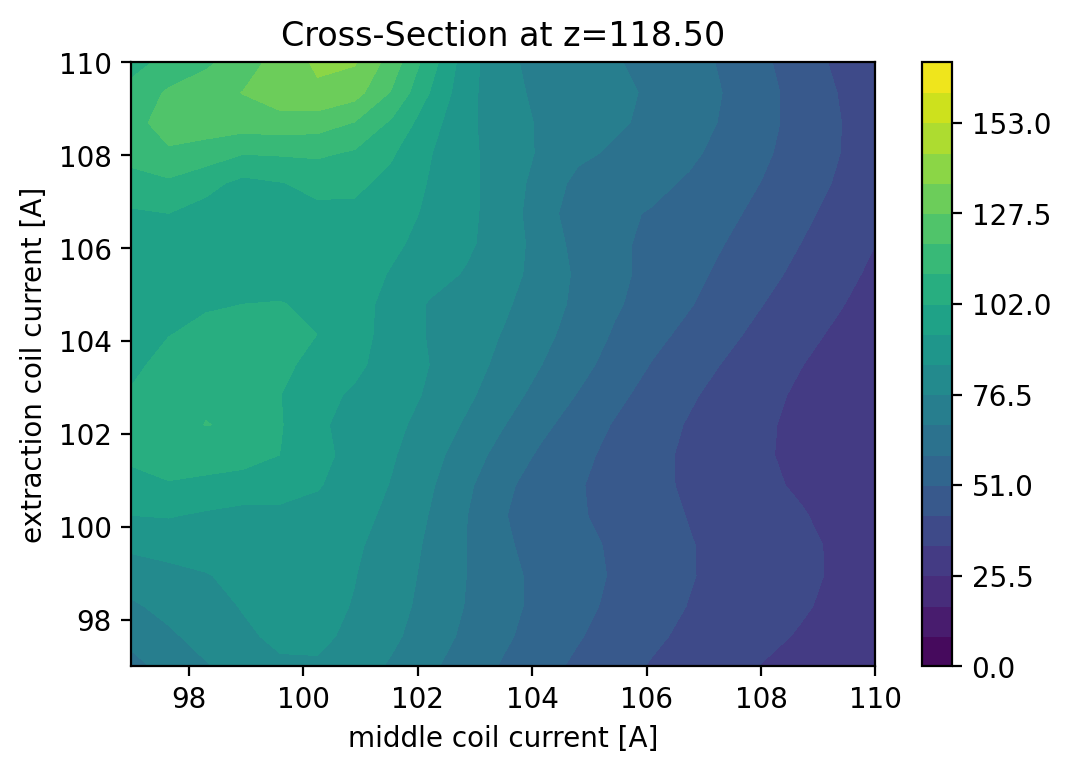

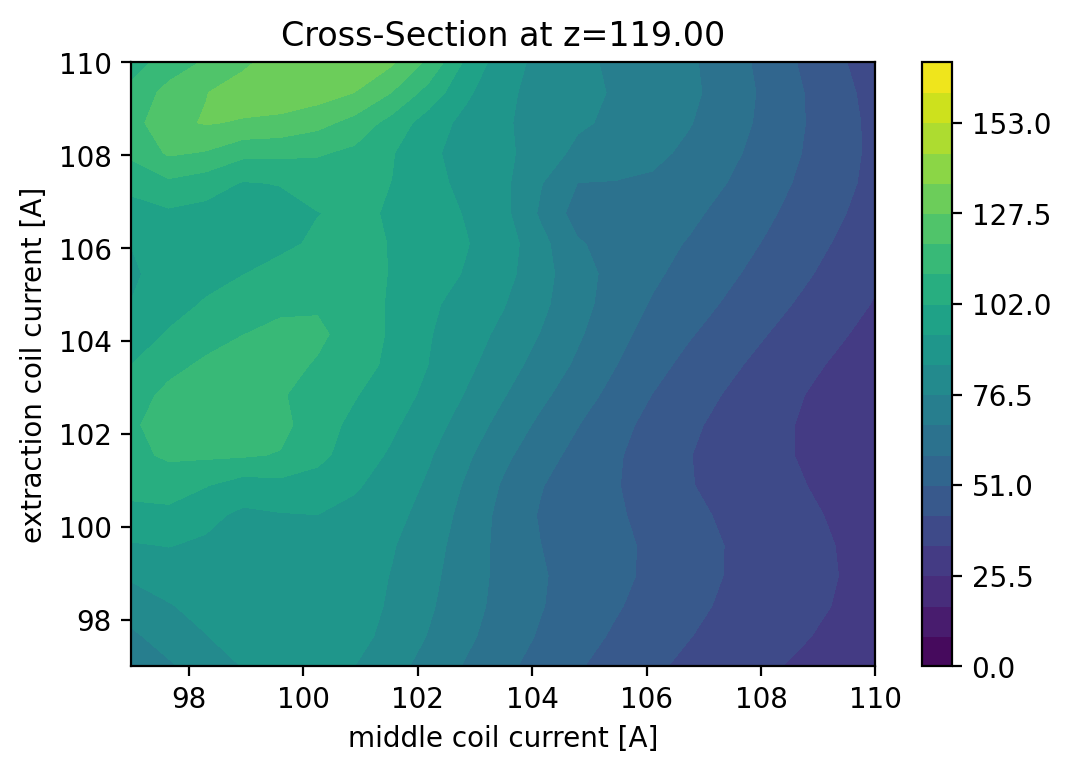

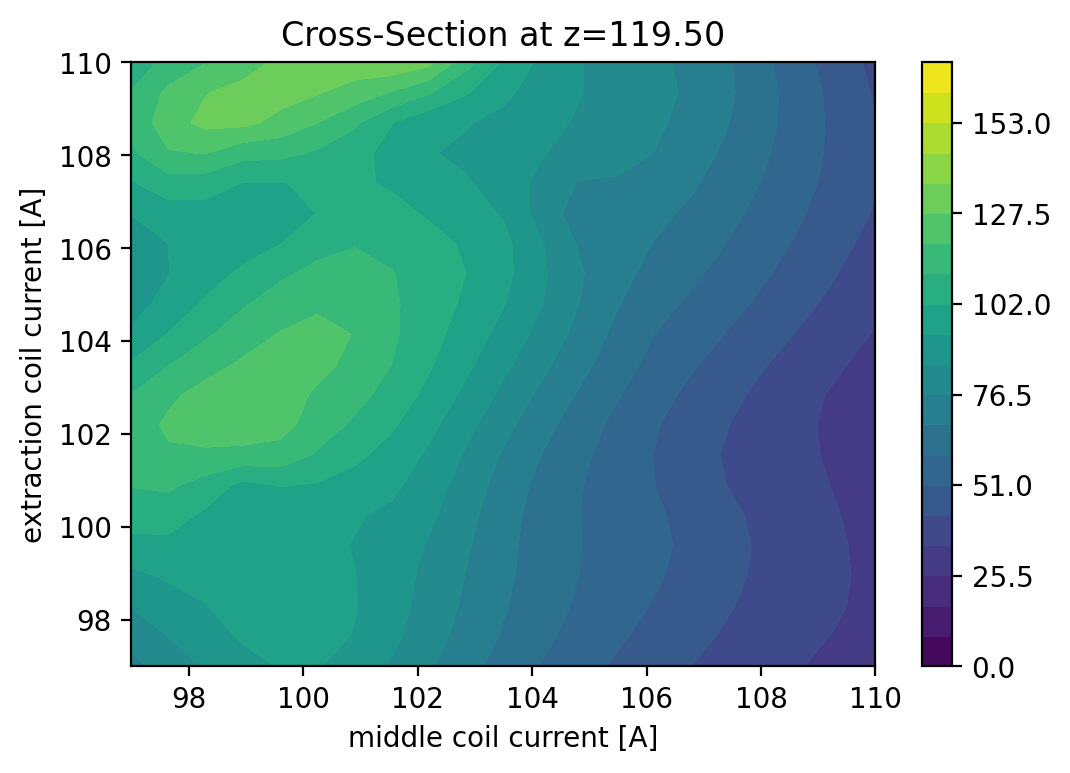

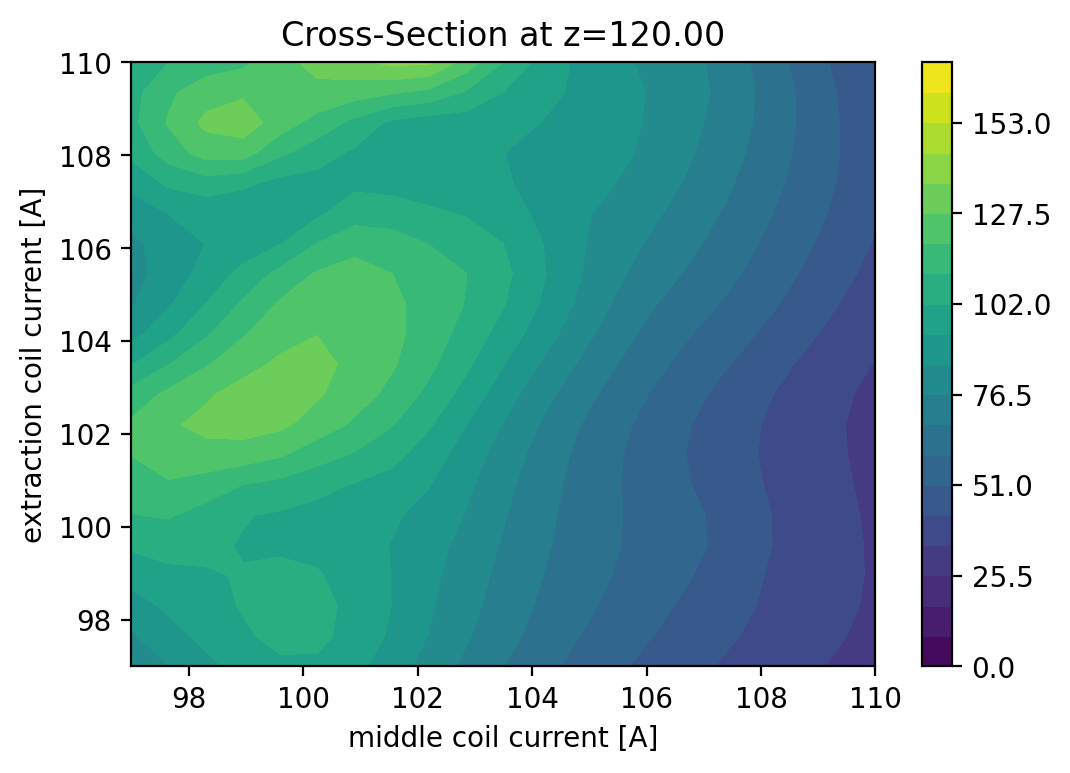

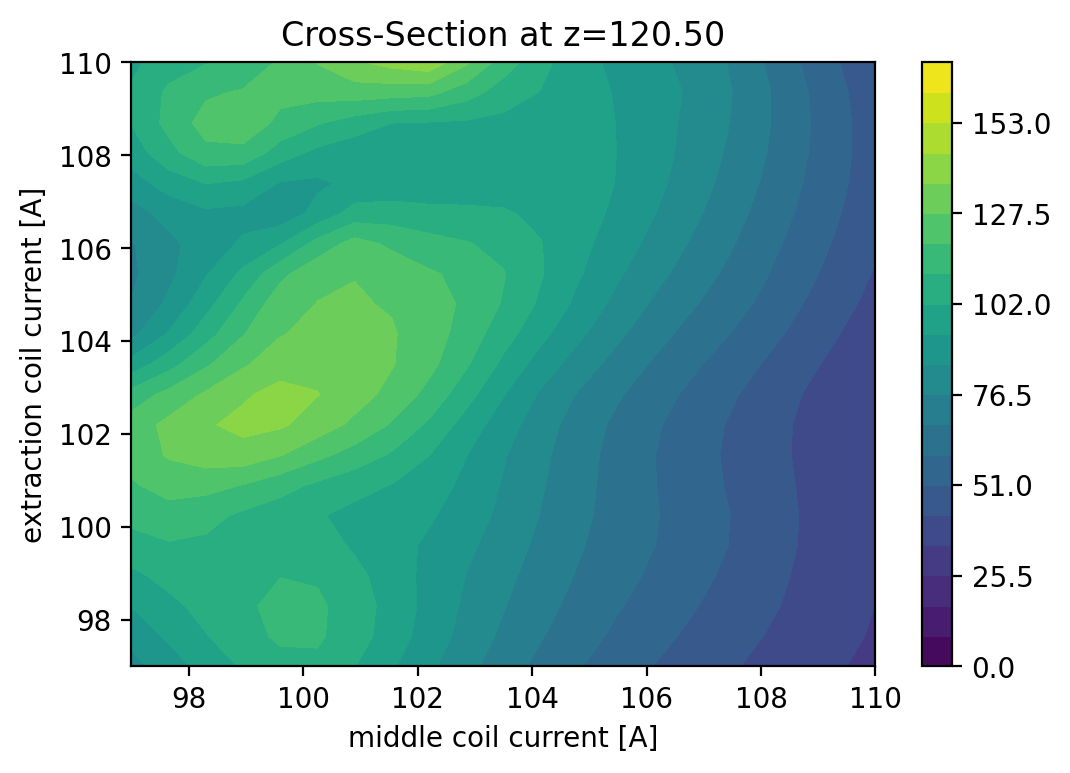

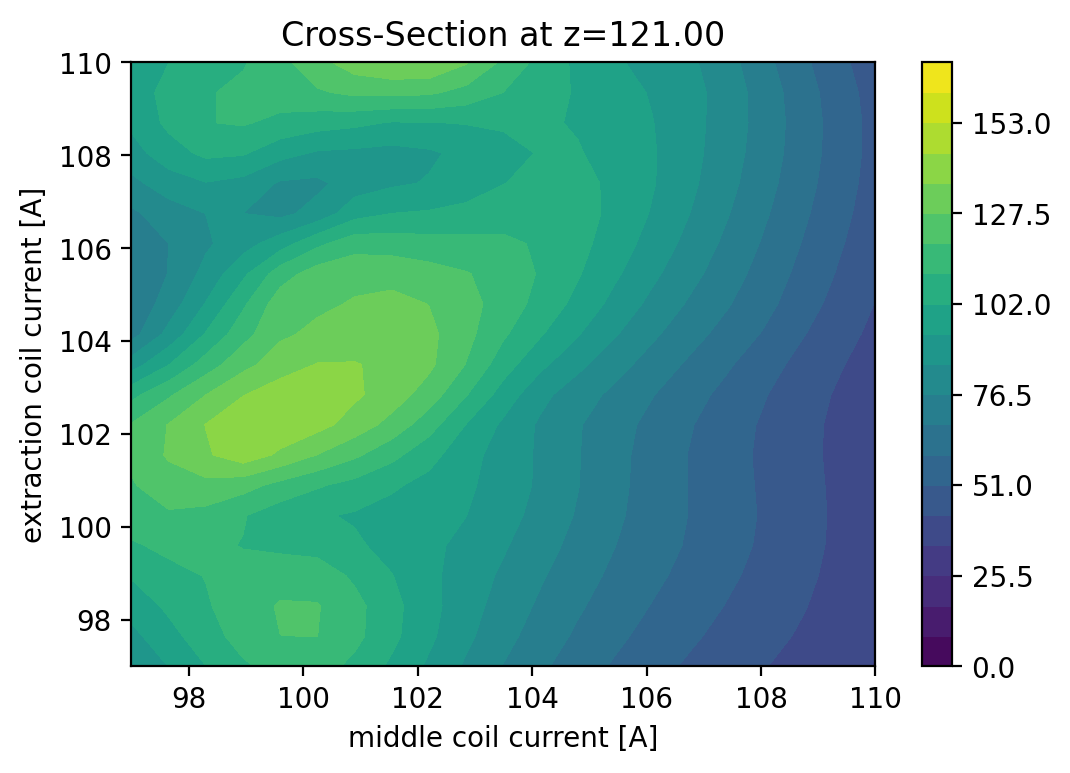

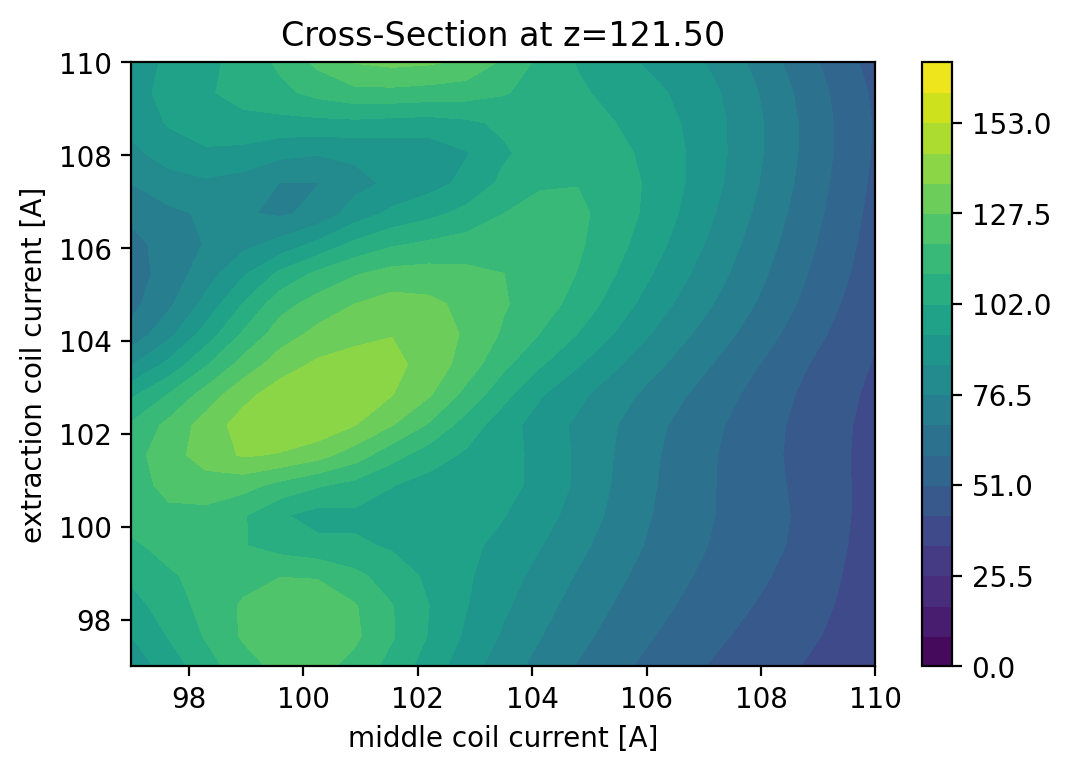

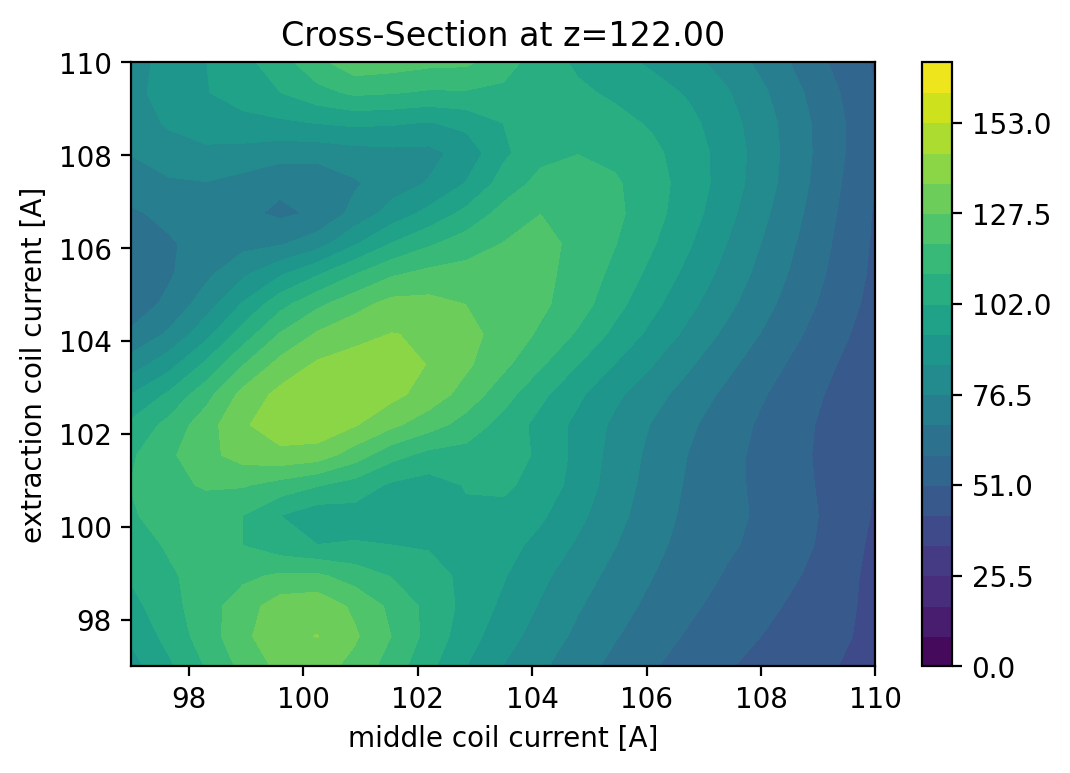

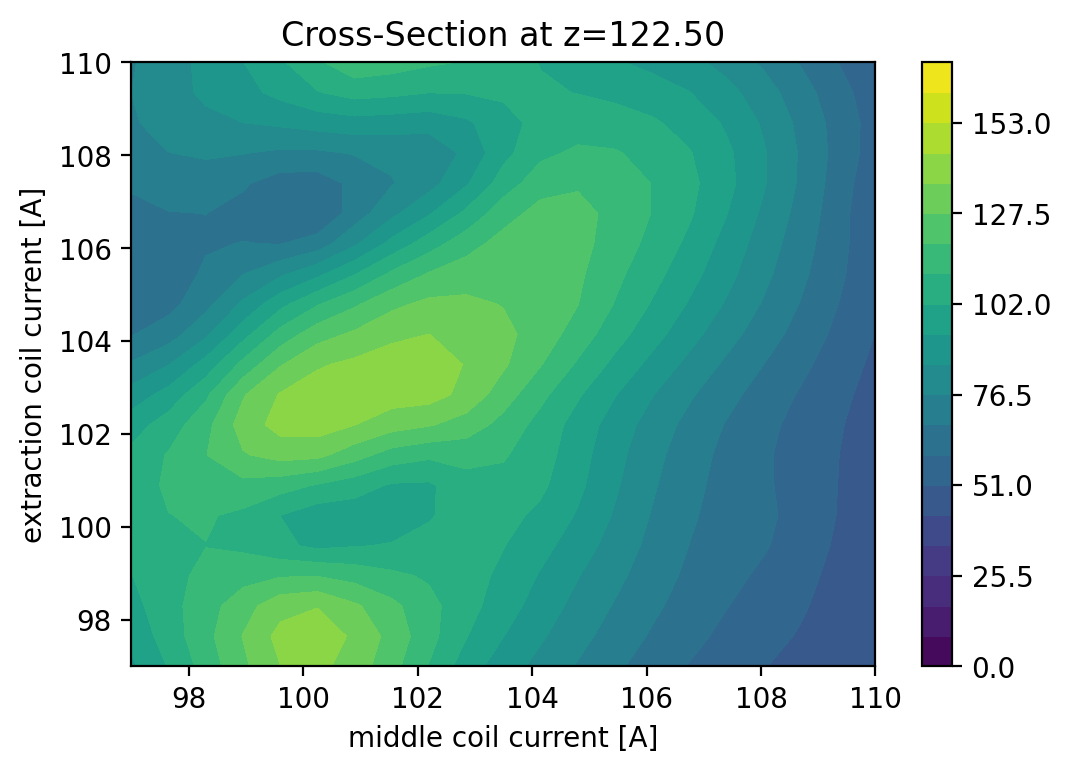

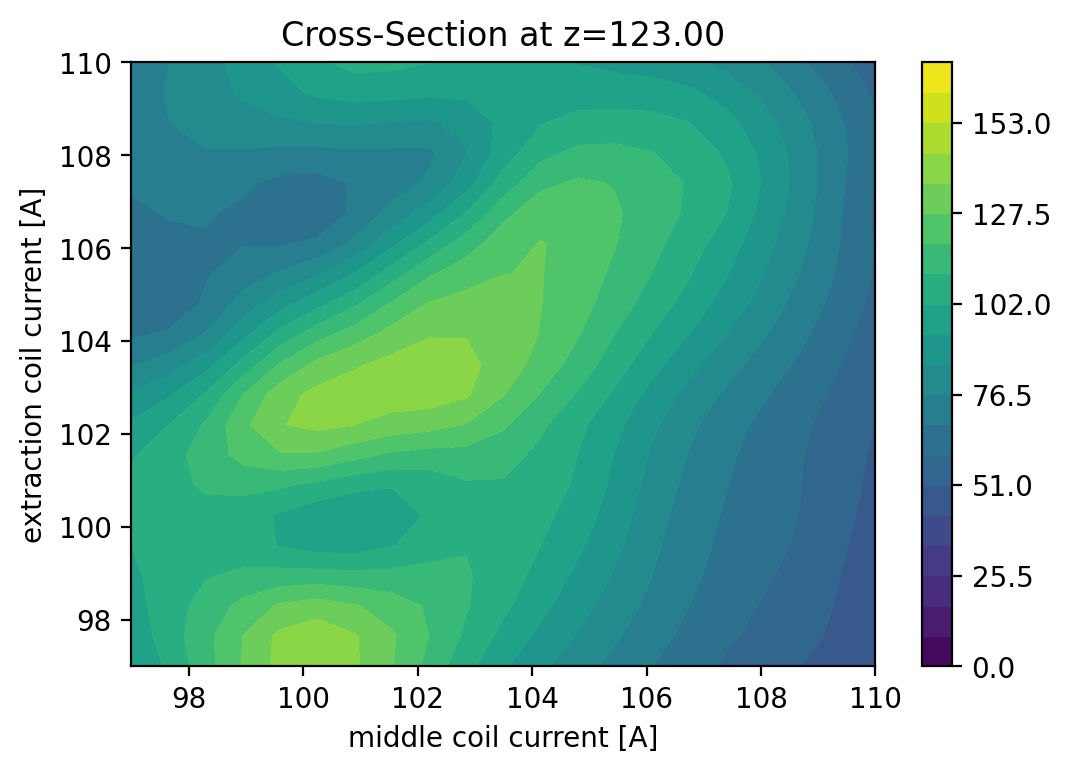

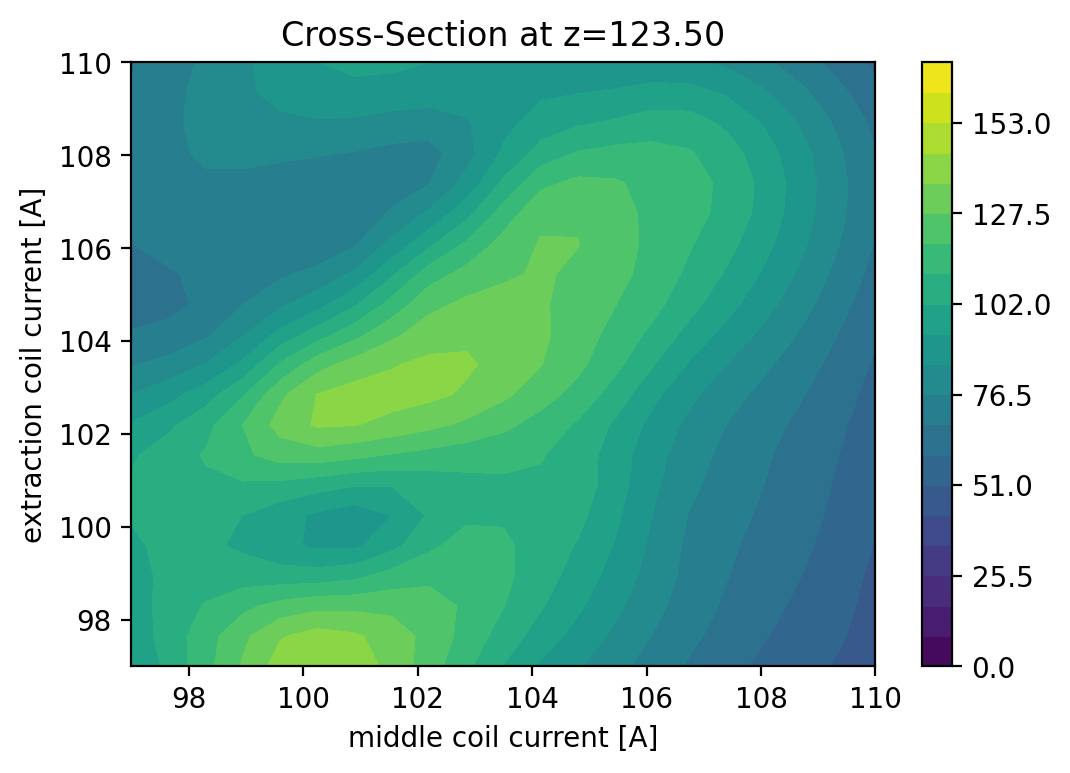

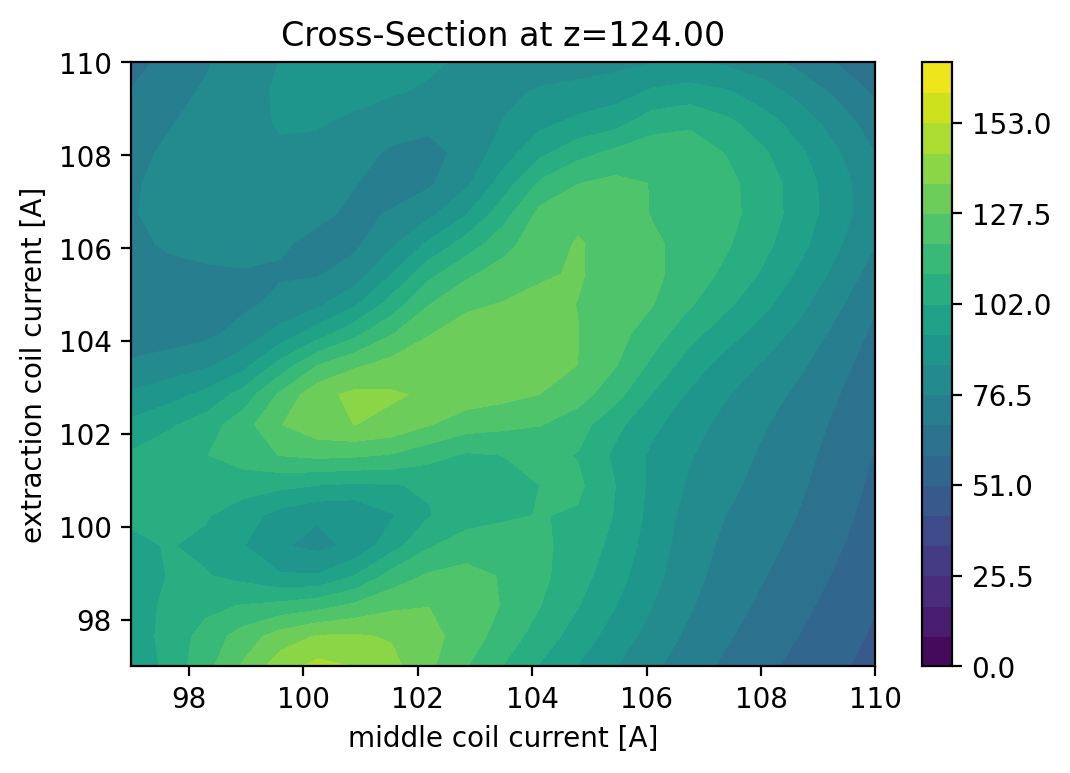

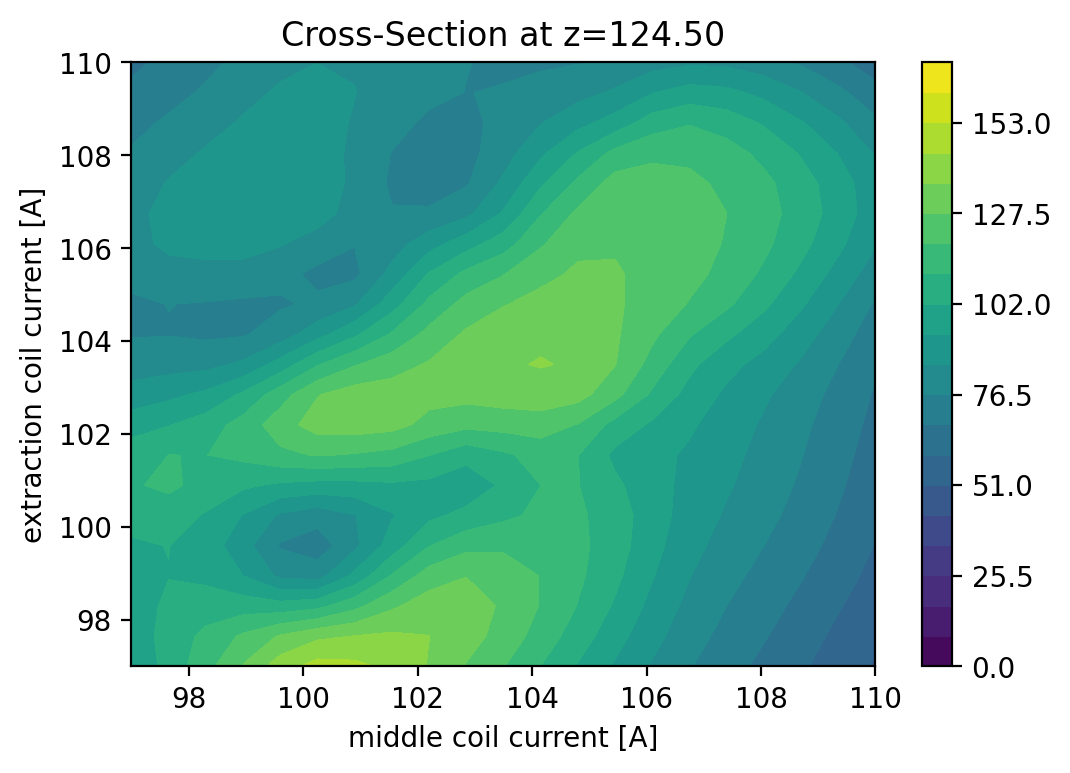

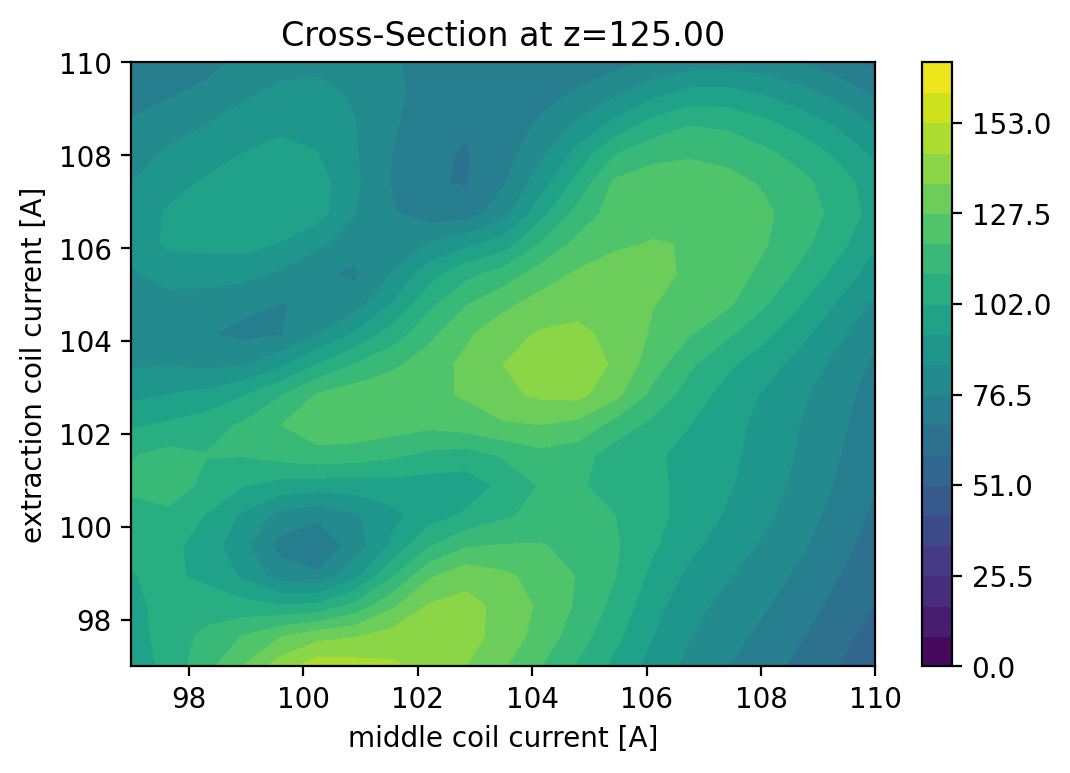

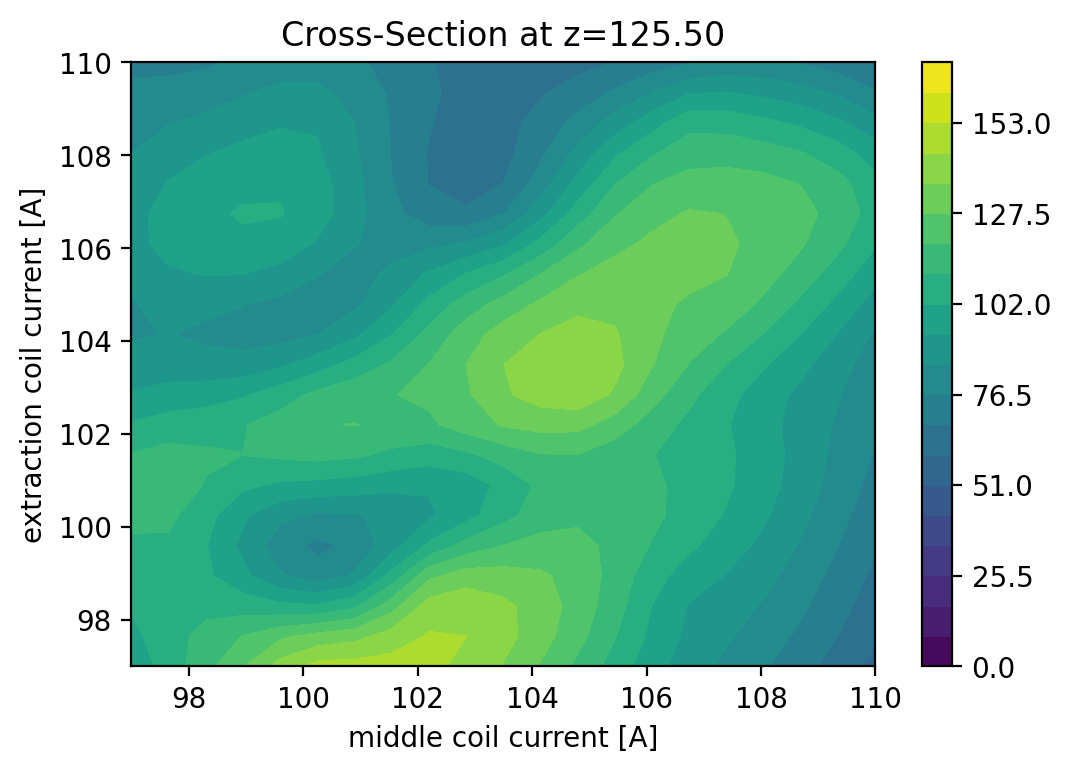

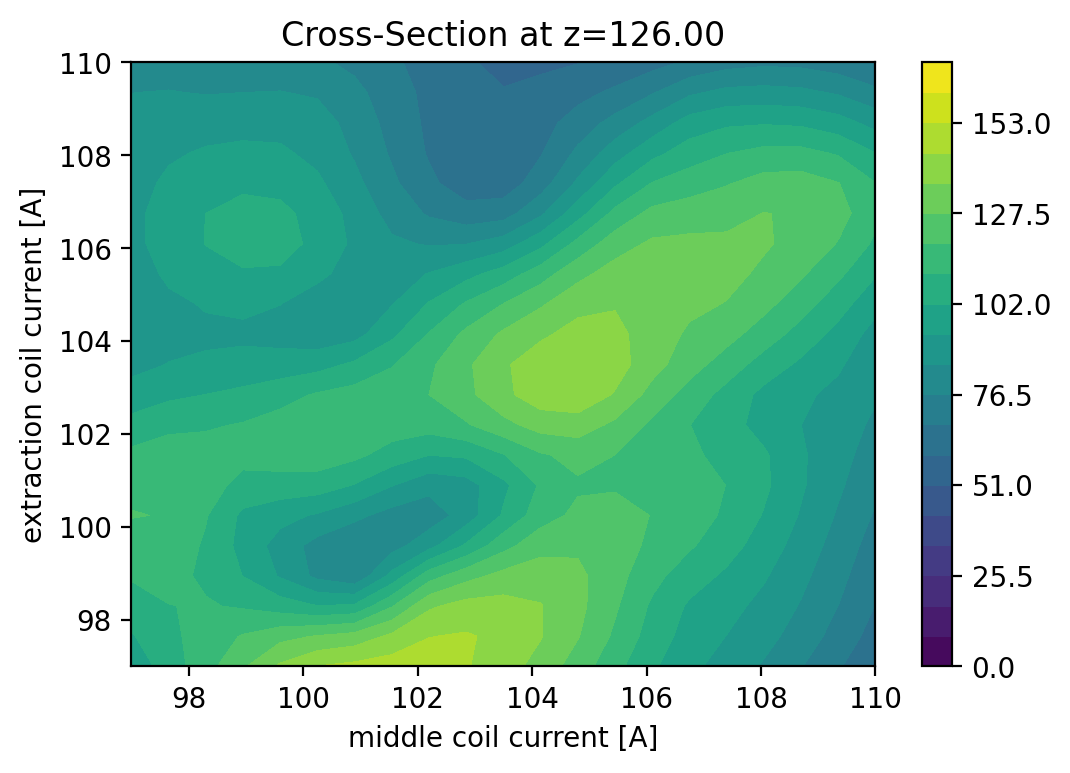

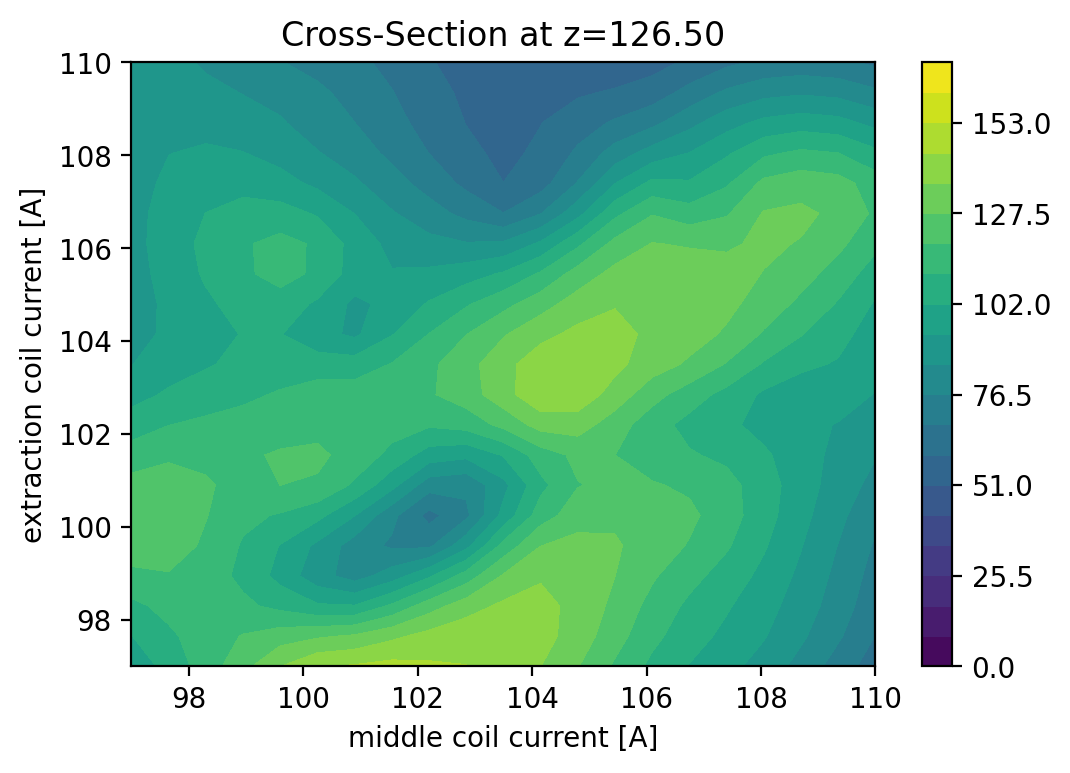

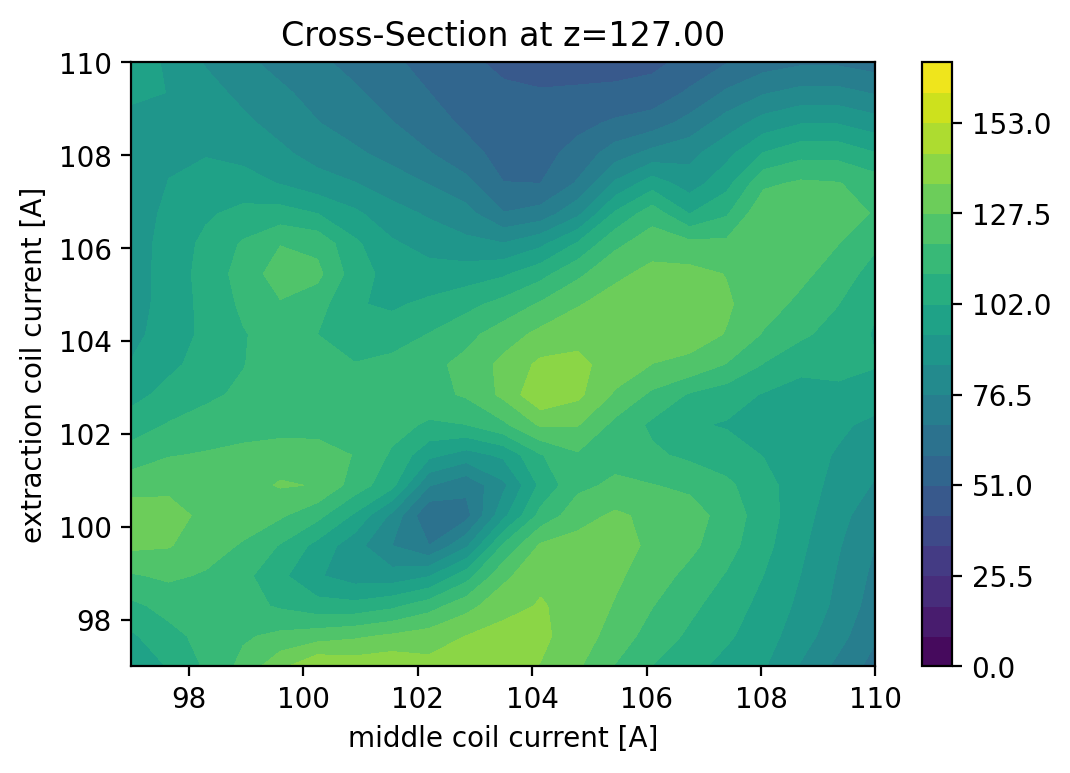

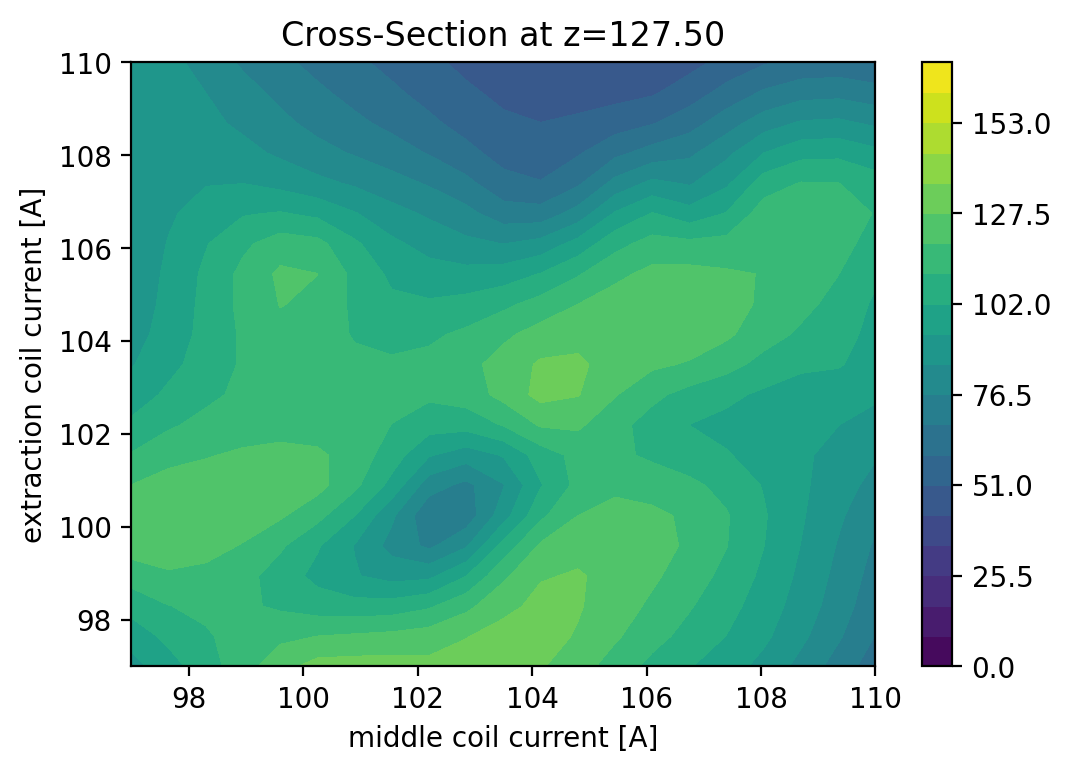

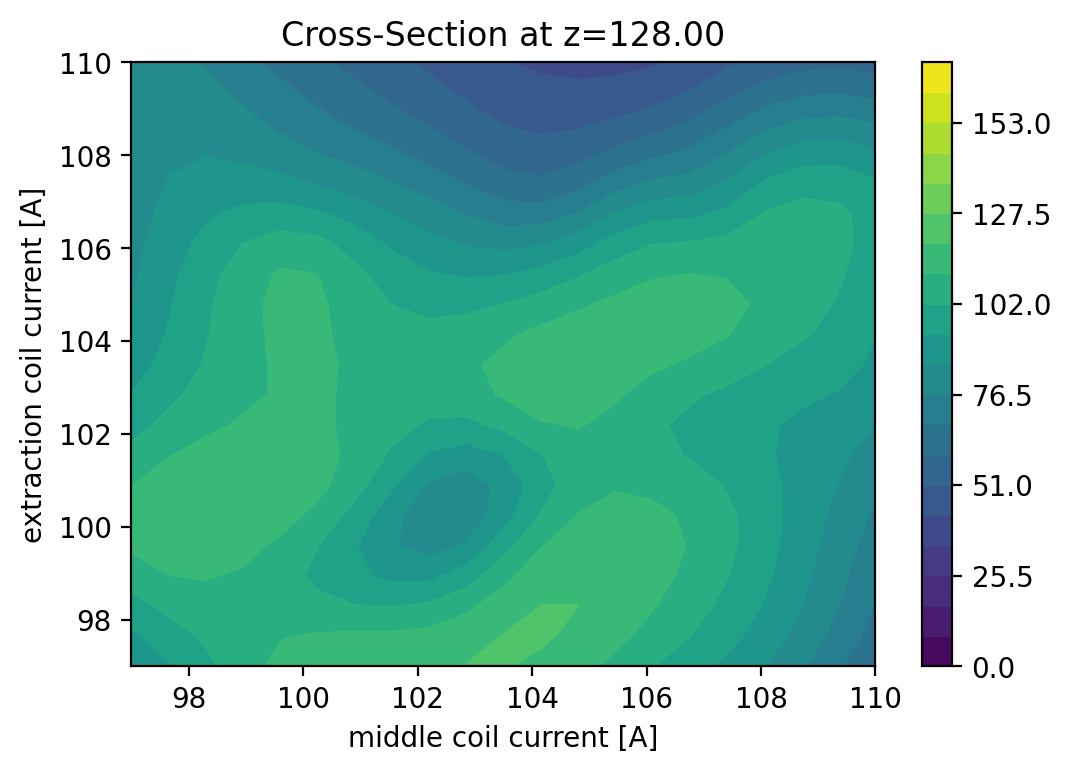

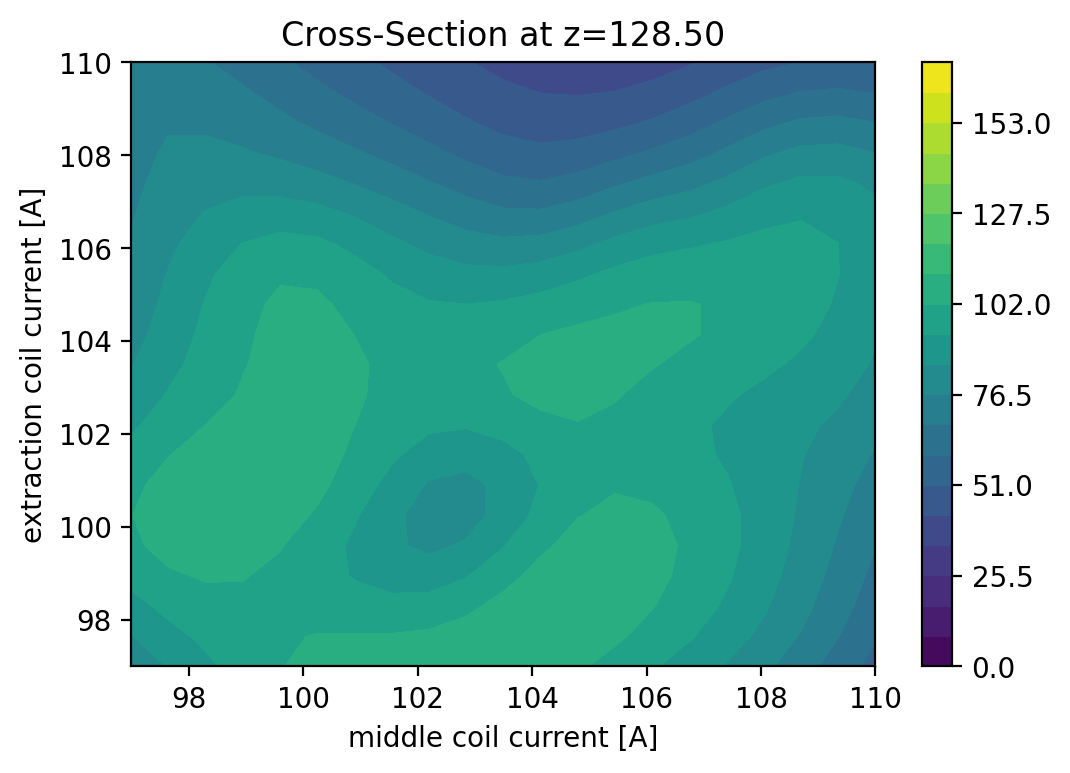

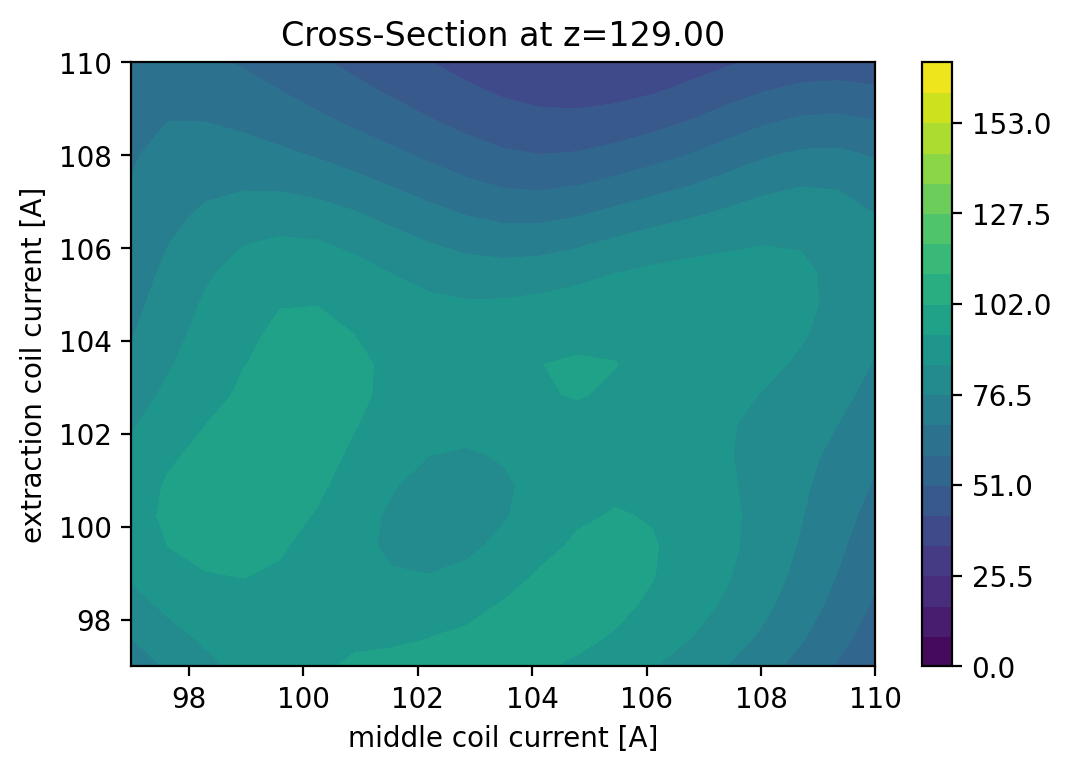

In [167]:
for z in np.linspace(116, 129, 27):
    plot_cross_section(gpr, z, plotVar=False)